### Uogulniona transformata Hougha

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread(r"/home/plorenc/Desktop/AiR_ISS/AVS/trybik.jpg", cv2.IMREAD_COLOR_RGB)
img2 = cv2.imread(r"/home/plorenc/Desktop/AiR_ISS/AVS/trybiki2.jpg", cv2.IMREAD_COLOR_RGB)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

bit_img1 = cv2.bitwise_not(img1_gray)
bit_img2 = cv2.bitwise_not(img2_gray)

def plot(img):
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [8]:
import numpy as np
import cv2
from scipy.spatial import distance

class HoughTransform:
    def __init__(self, img_init: np.ndarray):
        """
        Inicjalizuje transformację Hougha na podstawie obrazu wzorca.
        :param img_init: Obraz wzorcowy (np. trybik), w skali szarości.
        """
        self.img_init = ~img_init  # inwersja kolorów
        self.RTable = self.__compute_RTable()

    def get_RTable(self):
        return self.RTable

    def __compute_RTable(self):
        """
        Buduje R-table z obrazu wzorcowego.
        :return: RTable jako lista 360 elementów (dla każdego kąta w stopniach).
        """
        _, binary = cv2.threshold(self.img_init, 128, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        RTable = [[] for _ in range(360)]

        M = cv2.moments(binary, True)
        if M['m00'] == 0:
            return RTable  # zapobiega dzieleniu przez zero

        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Gradienty i orientacje
        sobelx = cv2.Sobel(binary, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(binary, cv2.CV_64F, 0, 1, ksize=5)
        mag = cv2.magnitude(sobelx, sobely)
        grad = mag / np.max(mag)
        orient = np.arctan2(sobely, sobelx)

        for contour in contours:
            for point in contour:
                x, y = point[0]
                if grad[y, x] < 0.2:
                    continue
                phi = int(np.rad2deg(orient[y, x])) % 360
                angle = int(np.rad2deg(np.arctan2(y - cy, x - cx))) % 360
                r = distance.euclidean((cx, cy), (x, y))
                RTable[phi].append((round(r), round(angle)))

        return RTable

    def apply(self, img: np.ndarray):
        """
        Wykonuje klasyczne dopasowanie wzorca bez rotacji.
        :param img: Obraz wejściowy (szary), w którym szukamy wzorca.
        :return: Akumulator 2D (liczba głosów).
        """
        img = ~img
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        grad = cv2.magnitude(sobelx, sobely)
        grad = grad / np.max(grad)
        orient = np.arctan2(sobely, sobelx)

        accumulator = np.zeros(img.shape, dtype=np.float32)

        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                if grad[y, x] < 0.5:
                    continue

                phi = int(np.rad2deg(orient[y, x])) % 360
                for r, angle in self.RTable[phi]:
                    x0 = int(x - r * np.cos(np.deg2rad(angle)))
                    y0 = int(y - r * np.sin(np.deg2rad(angle)))
                    if 0 <= x0 < accumulator.shape[1] and 0 <= y0 < accumulator.shape[0]:
                        accumulator[y0, x0] += 1

        return accumulator

    def apply_angle_orientate(self, img: np.ndarray):
        """
        Wykonuje dopasowanie wzorca z uwzględnieniem rotacji co 10°.
        :param img: Obraz wejściowy (szary), w którym szukamy wzorca.
        :return: 3D akumulator: [y, x, kąt] – lokalizacja + orientacja.
        """
        img = ~img
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
        grad = cv2.magnitude(sobelx, sobely)
        grad = grad / np.max(grad)
        orient = np.arctan2(sobely, sobelx)

        # Akumulator 3D: [wysokość, szerokość, liczba kątów]
        accumulator = np.zeros(img.shape + (36,), dtype=np.float32)

        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                if grad[y, x] < 0.5:
                    continue

                alpha = int(np.rad2deg(orient[y, x])) % 360  # kierunek gradientu

                for d_alpha in range(0, 360, 10):  # testowane rotacje
                    alpha_n = (alpha - d_alpha) % 360

                    for r, fi in self.RTable[alpha_n]:
                        fi_rot = np.deg2rad(fi + d_alpha)
                        x0 = int(x - r * np.cos(fi_rot))
                        y0 = int(y - r * np.sin(fi_rot))
                        rot_idx = d_alpha // 10

                        if 0 <= x0 < img.shape[1] and 0 <= y0 < img.shape[0]:
                            accumulator[y0, x0, rot_idx] += 1

        return accumulator


Najsilniejsze dopasowanie w punkcie: (101, 310)


/tmp/ipykernel_38480/411321313.py:14: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(accumulator).astype(np.uint8), cmap='hot')
/tmp/ipykernel_38480/411321313.py:14: RuntimeWarning: invalid value encountered in cast
  plt.imshow(np.log(accumulator).astype(np.uint8), cmap='hot')


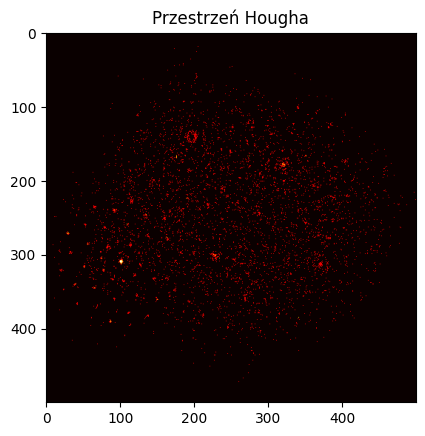

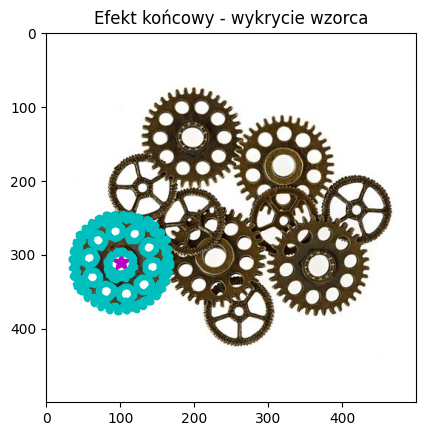

In [9]:
ht = HoughTransform(img1_gray)

accumulator = ht.apply(img2_gray)
accumulator_new = ht.apply_angle_orientate(img2_gray)

max_hough = np.unravel_index(np.argmax(accumulator), accumulator.shape)
print("Najsilniejsze dopasowanie w punkcie:", max_hough[::-1])

Rtable = ht.get_RTable()

# === Wizualizacje ===
plt.figure()
#$plt.imshow(accumulator * 255.0 / accumulator.max(), cmap='hot')
plt.imshow(np.log(accumulator).astype(np.uint8), cmap='hot')
plt.title('Przestrzeń Hougha')

plt.figure()
plt.imshow(img2, cmap='gray')
plt.plot(max_hough[1], max_hough[0], '*m', markersize=15)
plt.title('Efekt końcowy - wykrycie wzorca')

x_c = max_hough[0]
y_c = max_hough[1]
for i in range(0, 360):
    for one in Rtable[i]:
        r = one[0]
        fi = one[1]
        x = x_c - r * np.cos(np.deg2rad(fi))
        y = y_c - r * np.sin(np.deg2rad(fi))
        plt.plot(y, x, '.c')

plt.show()

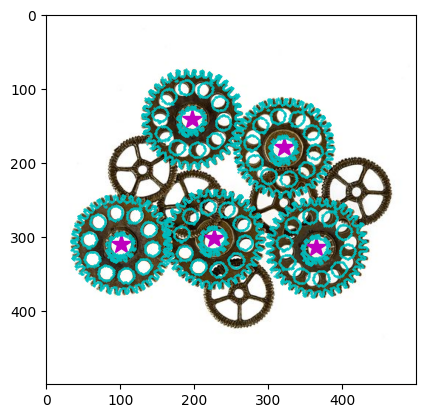

In [21]:
import numpy as np
import matplotlib.pyplot as plt

maxes = 5
eta = 100
maximum = []

acc_copy = accumulator_new.copy()

for idx in range(maxes):
    temp_max = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
    maximum.append(temp_max)

    acc_copy[
        temp_max[0] - eta: temp_max[0] + eta,
        temp_max[1] - eta: temp_max[1] + eta
    ] = 0

    #plt.imshow(acc_copy, cmap='hot')
    #plt.show()

plt.imshow(img2, cmap='gray')
for m in maximum:
    plt.plot(m[1], m[0], '*m', markersize=15)

df = 0  
for m in maximum:
    x_c, y_c = m[0], m[1]
    for angle in range(0, 360):
     #  if angle in Rtable:
            for r, fi in Rtable[angle]:
                x = x_c - r * np.cos(np.deg2rad(fi) + df)
                y = y_c - r * np.sin(np.deg2rad(fi) + df)
                plt.plot(y, x, '.c', markersize=1)
plt.show()


In [ ]:
Rtable

(70, 119)